In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Convolution2D
from keras.layers import Lambda, Cropping2D
import h5py
from sklearn.utils import shuffle
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from keras import optimizers
import csv

# Make the GPU memory expandable
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

samples = []
with open('C:\\SDC_Term1_Data\\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    source_path = 'C:\\SDC_Term1_Data\\IMG\\' + batch_sample[i].split('/')[-1]
                    image = cv2.imread(source_path)
                    images.append(image)
                    angle = float(line[3]) + (i == 1) * 0.2 + (i == 2) * (-0.2)
                    angles.append(angle)
                # name = batch_sample[0].split('/')[-1]
                # center_image = cv2.imread(name)
                # center_angle = float(batch_sample[3])
                # name_left = batch_sample[1].split('/')[-1]
                # left_image = cv2.imread(name_left)
                # name_right = batch_sample[2].split('/')[-1]
                # right_image = cv2.imread(name_right)
                # center_angle = float(batch_sample[3])
                # left_angle = float(batch_sample[3])
                # right_angle = float(batch_sample[3])
                # images.append(center_image)
                # angles.append(center_angle)
                # images.append(left_image)
                # angles.append(left_angle)
                # images.append(right_image)
                # angles.append(right_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [5]:
ch, row, col = 3, 80, 320  # Trimmed image format
# new NVidia model
model = Sequential()
model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))

# convolution layers with dropout
nb_filters = [24, 36, 48, 64, 64]
kernel_size = [(5, 5), (5, 5), (5, 5), (3, 3), (3, 3)]
same, valid = ('same', 'valid')
padding = [valid, valid, valid, valid, valid]
strides = [(2, 2), (2, 2), (2, 2), (1, 1), (1, 1)]
dropout = 0.4

for l in range(len(nb_filters)):
    model.add(Convolution2D(nb_filters[l],
                            kernel_size[l],
                            padding=padding[l],
                            strides=strides[l],
                            activation='elu'))
    model.add(Dropout(dropout))

# flatten layer
model.add(Flatten())

# fully connected layers with dropout
neurons = [100, 50, 10]
for l in range(len(neurons)):
    model.add(Dense(neurons[l], activation='elu'))
    model.add(Dropout(dropout))

# logit output - steering angle
model.add(Dense(1, activation='elu', name='Out'))

optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss='mse')

In [7]:
print('Now I am training the model')
import cv2
model_history = model.fit_generator(train_generator,
                    samples_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=2,
                    verbose=1)

Now I am training the model
Epoch 1/2


c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, steps_per_epoch=6429, epochs=2, validation_steps=1608)`
  


   1/6429 [..............................] - ETA: 30:56 - loss: 0.0308

   2/6429 [..............................] - ETA: 23:36 - loss: 0.0294

   3/6429 [..............................] - ETA: 22:56 - loss: 0.0285

   4/6429 [..............................] - ETA: 21:16 - loss: 0.0287

   5/6429 [..............................] - ETA: 20:36 - loss: 0.0281

   6/6429 [..............................] - ETA: 19:58 - loss: 0.0285

   7/6429 [..............................] - ETA: 19:25 - loss: 0.0291

   8/6429 [..............................] - ETA: 19:02 - loss: 0.0291

   9/6429 [..............................] - ETA: 18:41 - loss: 0.0292

  10/6429 [..............................] - ETA: 18:26 - loss: 0.0292

  11/6429 [..............................] - ETA: 18:08 - loss: 0.0289

  12/6429 [..............................] - ETA: 18:02 - loss: 0.0291

  13/6429 [..............................] - ETA: 17:45 - loss: 0.0292

  14/6429 [..............................] - ETA: 17:42 - loss: 0.0290

  15/6429 [..............................] - ETA: 17:34 - loss: 0.0293

  16/6429 [..............................] - ETA: 17:27 - loss: 0.0294

  17/6429 [..............................] - ETA: 17:20 - loss: 0.0287

  18/6429 [..............................] - ETA: 17:16 - loss: 0.0286

  19/6429 [..............................] - ETA: 17:10 - loss: 0.0288

  20/6429 [..............................] - ETA: 17:04 - loss: 0.0286

  21/6429 [..............................] - ETA: 17:02 - loss: 0.0284

  22/6429 [..............................] - ETA: 17:01 - loss: 0.0281

  23/6429 [..............................] - ETA: 16:54 - loss: 0.0279

  24/6429 [..............................] - ETA: 16:54 - loss: 0.0280

  25/6429 [..............................] - ETA: 16:50 - loss: 0.0281

  26/6429 [..............................] - ETA: 16:47 - loss: 0.0281

  27/6429 [..............................] - ETA: 16:44 - loss: 0.0280

  28/6429 [..............................] - ETA: 16:41 - loss: 0.0281

  29/6429 [..............................] - ETA: 16:39 - loss: 0.0280

  30/6429 [..............................] - ETA: 16:38 - loss: 0.0279

  31/6429 [..............................] - ETA: 16:35 - loss: 0.0279

  32/6429 [..............................] - ETA: 16:33 - loss: 0.0278

  33/6429 [..............................] - ETA: 16:31 - loss: 0.0277

  34/6429 [..............................] - ETA: 16:29 - loss: 0.0277

  35/6429 [..............................] - ETA: 16:27 - loss: 0.0277

  36/6429 [..............................] - ETA: 16:27 - loss: 0.0276

  37/6429 [..............................] - ETA: 16:25 - loss: 0.0275

  38/6429 [..............................] - ETA: 16:23 - loss: 0.0273

  39/6429 [..............................] - ETA: 16:22 - loss: 0.0272

  40/6429 [..............................] - ETA: 16:20 - loss: 0.0272

  41/6429 [..............................] - ETA: 16:18 - loss: 0.0272

  42/6429 [..............................] - ETA: 16:17 - loss: 0.0273

  43/6429 [..............................] - ETA: 16:17 - loss: 0.0271

  44/6429 [..............................] - ETA: 16:16 - loss: 0.0273

  45/6429 [..............................] - ETA: 16:14 - loss: 0.0273

  46/6429 [..............................] - ETA: 16:13 - loss: 0.0272

  47/6429 [..............................] - ETA: 16:14 - loss: 0.0271

  48/6429 [..............................] - ETA: 16:16 - loss: 0.0270

  49/6429 [..............................] - ETA: 16:15 - loss: 0.0270

  50/6429 [..............................] - ETA: 16:13 - loss: 0.0270

  51/6429 [..............................] - ETA: 16:12 - loss: 0.0270

  52/6429 [..............................] - ETA: 16:11 - loss: 0.0270

  53/6429 [..............................] - ETA: 16:10 - loss: 0.0270

  54/6429 [..............................] - ETA: 16:10 - loss: 0.0269

  55/6429 [..............................] - ETA: 16:09 - loss: 0.0268

  56/6429 [..............................] - ETA: 16:09 - loss: 0.0268

  57/6429 [..............................] - ETA: 16:09 - loss: 0.0268

  58/6429 [..............................] - ETA: 16:08 - loss: 0.0268

  59/6429 [..............................] - ETA: 16:07 - loss: 0.0268

  60/6429 [..............................] - ETA: 16:07 - loss: 0.0268

  61/6429 [..............................] - ETA: 16:06 - loss: 0.0268

  62/6429 [..............................] - ETA: 16:07 - loss: 0.0268

  63/6429 [..............................] - ETA: 16:06 - loss: 0.0267

  64/6429 [..............................] - ETA: 16:06 - loss: 0.0267

  65/6429 [..............................] - ETA: 16:04 - loss: 0.0268

  66/6429 [..............................] - ETA: 16:04 - loss: 0.0267

  67/6429 [..............................] - ETA: 16:03 - loss: 0.0267

  68/6429 [..............................] - ETA: 16:04 - loss: 0.0267

  69/6429 [..............................] - ETA: 16:03 - loss: 0.0267

  70/6429 [..............................] - ETA: 16:03 - loss: 0.0267

  71/6429 [..............................] - ETA: 16:00 - loss: 0.0266

  72/6429 [..............................] - ETA: 16:00 - loss: 0.0266

  73/6429 [..............................] - ETA: 16:00 - loss: 0.0266

  74/6429 [..............................] - ETA: 15:59 - loss: 0.0266

  75/6429 [..............................] - ETA: 15:59 - loss: 0.0265

  76/6429 [..............................] - ETA: 15:58 - loss: 0.0265

  77/6429 [..............................] - ETA: 15:58 - loss: 0.0265

  78/6429 [..............................] - ETA: 15:57 - loss: 0.0265

  79/6429 [..............................] - ETA: 15:57 - loss: 0.0264

  80/6429 [..............................] - ETA: 15:56 - loss: 0.0263

  81/6429 [..............................] - ETA: 15:56 - loss: 0.0263

  82/6429 [..............................] - ETA: 15:57 - loss: 0.0263

  83/6429 [..............................] - ETA: 15:57 - loss: 0.0262

  84/6429 [..............................] - ETA: 15:56 - loss: 0.0262

  85/6429 [..............................] - ETA: 15:56 - loss: 0.0261

  86/6429 [..............................] - ETA: 15:55 - loss: 0.0261

  87/6429 [..............................] - ETA: 15:55 - loss: 0.0260

  88/6429 [..............................] - ETA: 15:54 - loss: 0.0260

  89/6429 [..............................] - ETA: 15:54 - loss: 0.0260

  90/6429 [..............................] - ETA: 15:54 - loss: 0.0260

  91/6429 [..............................] - ETA: 15:54 - loss: 0.0259

  92/6429 [..............................] - ETA: 15:54 - loss: 0.0258

  93/6429 [..............................] - ETA: 15:53 - loss: 0.0258

  94/6429 [..............................] - ETA: 15:54 - loss: 0.0258

  95/6429 [..............................] - ETA: 15:53 - loss: 0.0258

  96/6429 [..............................] - ETA: 15:53 - loss: 0.0257

  97/6429 [..............................] - ETA: 15:53 - loss: 0.0257

  98/6429 [..............................] - ETA: 15:52 - loss: 0.0257

  99/6429 [..............................] - ETA: 15:53 - loss: 0.0256

 100/6429 [..............................] - ETA: 15:51 - loss: 0.0256

 101/6429 [..............................] - ETA: 15:52 - loss: 0.0255

 102/6429 [..............................] - ETA: 15:51 - loss: 0.0256

 103/6429 [..............................] - ETA: 15:50 - loss: 0.0256

 104/6429 [..............................] - ETA: 15:50 - loss: 0.0255

 105/6429 [..............................] - ETA: 15:50 - loss: 0.0255

 106/6429 [..............................] - ETA: 15:49 - loss: 0.0254

 107/6429 [..............................] - ETA: 15:49 - loss: 0.0254

 108/6429 [..............................] - ETA: 15:48 - loss: 0.0254

 109/6429 [..............................] - ETA: 15:48 - loss: 0.0254

 110/6429 [..............................] - ETA: 15:48 - loss: 0.0254

 111/6429 [..............................] - ETA: 15:47 - loss: 0.0254

 112/6429 [..............................] - ETA: 15:46 - loss: 0.0255

 113/6429 [..............................] - ETA: 15:47 - loss: 0.0254

 114/6429 [..............................] - ETA: 15:46 - loss: 0.0254

 115/6429 [..............................] - ETA: 15:46 - loss: 0.0254

 116/6429 [..............................] - ETA: 15:45 - loss: 0.0254

 117/6429 [..............................] - ETA: 15:45 - loss: 0.0254

 118/6429 [..............................] - ETA: 15:45 - loss: 0.0254

 119/6429 [..............................] - ETA: 15:44 - loss: 0.0254

 120/6429 [..............................] - ETA: 15:44 - loss: 0.0254

 121/6429 [..............................] - ETA: 15:44 - loss: 0.0254

 122/6429 [..............................] - ETA: 15:43 - loss: 0.0254

 123/6429 [..............................] - ETA: 15:43 - loss: 0.0253

 124/6429 [..............................] - ETA: 15:42 - loss: 0.0253

 125/6429 [..............................] - ETA: 15:42 - loss: 0.0252

 126/6429 [..............................] - ETA: 15:41 - loss: 0.0252

 127/6429 [..............................] - ETA: 15:41 - loss: 0.0252

 128/6429 [..............................] - ETA: 15:40 - loss: 0.0252

 129/6429 [..............................] - ETA: 15:40 - loss: 0.0251

 130/6429 [..............................] - ETA: 15:40 - loss: 0.0251

 131/6429 [..............................] - ETA: 15:40 - loss: 0.0250

 132/6429 [..............................] - ETA: 15:39 - loss: 0.0250

 133/6429 [..............................] - ETA: 15:39 - loss: 0.0250

 134/6429 [..............................] - ETA: 15:39 - loss: 0.0250

 135/6429 [..............................] - ETA: 15:38 - loss: 0.0249

 136/6429 [..............................] - ETA: 15:38 - loss: 0.0249

 137/6429 [..............................] - ETA: 15:38 - loss: 0.0249

 138/6429 [..............................] - ETA: 15:38 - loss: 0.0249

 139/6429 [..............................] - ETA: 15:38 - loss: 0.0249

 140/6429 [..............................] - ETA: 15:37 - loss: 0.0249

 141/6429 [..............................] - ETA: 15:37 - loss: 0.0248

 142/6429 [..............................] - ETA: 15:37 - loss: 0.0248

 143/6429 [..............................] - ETA: 15:37 - loss: 0.0249

 144/6429 [..............................] - ETA: 15:36 - loss: 0.0249

 145/6429 [..............................] - ETA: 15:36 - loss: 0.0249

 146/6429 [..............................] - ETA: 15:36 - loss: 0.0249

 147/6429 [..............................] - ETA: 15:36 - loss: 0.0249

 148/6429 [..............................] - ETA: 15:36 - loss: 0.0248

 149/6429 [..............................] - ETA: 15:36 - loss: 0.0248

 150/6429 [..............................] - ETA: 15:36 - loss: 0.0248

 151/6429 [..............................] - ETA: 15:35 - loss: 0.0247

 152/6429 [..............................] - ETA: 15:35 - loss: 0.0248

 153/6429 [..............................] - ETA: 15:35 - loss: 0.0247

 154/6429 [..............................] - ETA: 15:35 - loss: 0.0247

 155/6429 [..............................] - ETA: 15:35 - loss: 0.0247

 156/6429 [..............................] - ETA: 15:34 - loss: 0.0247

 157/6429 [..............................] - ETA: 15:34 - loss: 0.0247

 158/6429 [..............................] - ETA: 15:34 - loss: 0.0247

 159/6429 [..............................] - ETA: 15:34 - loss: 0.0247

 160/6429 [..............................] - ETA: 15:34 - loss: 0.0247

 161/6429 [..............................] - ETA: 15:34 - loss: 0.0247

 162/6429 [..............................] - ETA: 15:33 - loss: 0.0247

 163/6429 [..............................] - ETA: 15:33 - loss: 0.0246

 164/6429 [..............................] - ETA: 15:33 - loss: 0.0246

 165/6429 [..............................] - ETA: 15:33 - loss: 0.0246

 166/6429 [..............................] - ETA: 15:33 - loss: 0.0246

 167/6429 [..............................] - ETA: 15:33 - loss: 0.0246

 168/6429 [..............................] - ETA: 15:33 - loss: 0.0246

 169/6429 [..............................] - ETA: 15:32 - loss: 0.0245

 170/6429 [..............................] - ETA: 15:33 - loss: 0.0245

 171/6429 [..............................] - ETA: 15:33 - loss: 0.0245

 172/6429 [..............................] - ETA: 15:32 - loss: 0.0245

 173/6429 [..............................] - ETA: 15:32 - loss: 0.0245

 174/6429 [..............................] - ETA: 15:32 - loss: 0.0244

 175/6429 [..............................] - ETA: 15:32 - loss: 0.0244

 176/6429 [..............................] - ETA: 15:32 - loss: 0.0244

 177/6429 [..............................] - ETA: 15:32 - loss: 0.0244

 178/6429 [..............................] - ETA: 15:32 - loss: 0.0244

 179/6429 [..............................] - ETA: 15:32 - loss: 0.0243

 180/6429 [..............................] - ETA: 15:32 - loss: 0.0243

 181/6429 [..............................] - ETA: 15:31 - loss: 0.0243

 182/6429 [..............................] - ETA: 15:31 - loss: 0.0243

 183/6429 [..............................] - ETA: 15:31 - loss: 0.0243

 184/6429 [..............................] - ETA: 15:31 - loss: 0.0243

 185/6429 [..............................] - ETA: 15:31 - loss: 0.0242

 186/6429 [..............................] - ETA: 15:31 - loss: 0.0242

 187/6429 [..............................] - ETA: 15:31 - loss: 0.0242

 188/6429 [..............................] - ETA: 15:30 - loss: 0.0242

 189/6429 [..............................] - ETA: 15:30 - loss: 0.0242

 190/6429 [..............................] - ETA: 15:30 - loss: 0.0242

 191/6429 [..............................] - ETA: 15:30 - loss: 0.0241

 192/6429 [..............................] - ETA: 15:30 - loss: 0.0241

 193/6429 [..............................] - ETA: 15:30 - loss: 0.0241

 194/6429 [..............................] - ETA: 15:30 - loss: 0.0241

 195/6429 [..............................] - ETA: 15:29 - loss: 0.0241

 196/6429 [..............................] - ETA: 15:29 - loss: 0.0241

 197/6429 [..............................] - ETA: 15:29 - loss: 0.0241

 198/6429 [..............................] - ETA: 15:29 - loss: 0.0241

 199/6429 [..............................] - ETA: 15:29 - loss: 0.0241

ValueError: Error when checking input: expected lambda_2_input to have 4 dimensions, but got array with shape (96, 1)

In [71]:
model.save('C:\\Users\\zypch\\Documents\\Learning\\SDC_Term1\\CarND-Behavioral-Cloning-P3\\test2.h5')
print('Model saved')

Model saved


In [73]:
print(model_history.history.keys())

dict_keys(['val_loss', 'loss'])


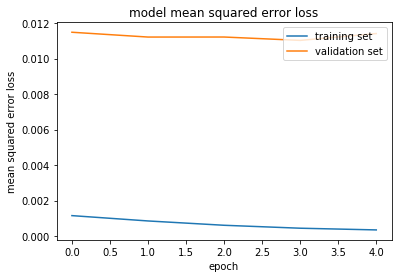

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
ax=plt.gca()
plt.show()